In [1]:
# Load Kaggle API Token
from google.colab import files
!pip install -q kaggle > /dev/null
uploaded = files.upload()
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

# Load Data
!kaggle competitions download -c tensorflow-speech-recognition-challenge > /dev/null

# Unzip Data
!apt-get install p7zip-full > /dev/null
!p7zip -d train.7z > /dev/null
# !p7zip -d test.7z > /dev/null

Saving kaggle.json to kaggle.json
100% 50.0/50.0 [00:00<00:00, 91.7kB/s]
100% 1.04G/1.04G [00:20<00:00, 55.2MB/s]
100% 501k/501k [00:00<00:00, 33.5MB/s]
100% 2.46G/2.46G [00:45<00:00, 58.2MB/s]


In [2]:
from scipy.io import wavfile
from IPython.display import Audio
from os import walk
from matplotlib import pyplot as plt

debug = False

train_audio_path = '/content/train/audio/'

# Load all filenames into a dictionary so we can call on them easily
files = {}
count = 0
for (dirpath, dirnames, filenames) in walk(train_audio_path):
  files[dirpath[21:]] = filenames
  count += len(filenames)
  
print("Number of Audio signals:", count)
if debug:
  # Look at a small part of the dictionary
  for label, samples in files.items():
    print(label, '\t', samples[0:5])

Number of Audio signals: 64728


In [3]:
import librosa
import librosa.display
from scipy import signal
import numpy as np

def loadData(files):
  # Build Dataset
  new_rate = 8000
  xtrain, ytrain = [], []
  count = 0
  for label, filenames in files.items():
    if label not in ['', '_background_noise_']:
      for i, filename in enumerate(filenames[:1000]):
        audio, new_rate = librosa.load(train_audio_path + label + '/' + filename, sr=new_rate)
        audio = pad_audio(audio)
        _, _, spectogram = log_specgram(audio, sample_rate=new_rate)
      
      
        if len(audio) != 8000:
          print("HI")
        else:
          xtrain.append(spectogram)
          ytrain.append(label)
      
      count += len(filenames)
      print(count / 64728)

        # mfccs = librosa.feature.mfcc(y=audio, sr=new_rate, n_mfcc = 50)
        # mfccs_processed = np.mean(mfccs.T,axis=0)
        
  return np.array(xtrain), np.array(ytrain)

def onehot(A, mapping=None):
  labels = set(['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'unknown'])
  
  if mapping is None:
    mapping = {}
    for i, label in enumerate(labels):
      temp = [0] * len(labels)
      temp[i] = 1
      mapping[label] = temp
    
  res = []
  for label in A:
    if label == '_background_noise_':
      res.append(mapping['silence'])
    elif label in labels:
      res.append(mapping[label])
    else:
      res.append(mapping['unknown'])
  
  return np.array(res), mapping

def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)
    
def normalize(x):
  minX = np.amin(x)
  maxX = np.amax(x)
  gap = maxX - minX

  return (x - (minX + 0.5*gap)) / (0.5 * gap)

def pad_audio(samples):
    if len(samples) >= 8000: return samples
    else: 
      return np.pad(samples, pad_width=(8000 - len(samples), 0), mode='constant', constant_values=(0, 0))

In [4]:
X, Y = loadData(files)

0.0364139166975652
0.06338833271536275
0.09991039426523297
0.13660239772586824
0.1731708070695835
0.20977011494252873
0.23672908169571127
0.2731738969225065
0.30952601656161166
0.3364386355209492
0.3731615375108145
0.39993511308861696
0.4363335805215672
0.4627981708070696
0.49952107279693486
0.5361358299344952
0.5628785069830676
0.5992151773575578
0.6259887529353603
0.6626962056606106
0.6993418613274008
0.7357557780249661
0.7625448028673835
0.7992368063280187
0.8358824619948091
0.8726517117785193
0.8996261277963169
0.9361945371400321
0.9728556420714374
0.999891855147695


In [5]:
from sklearn.model_selection import train_test_split

# X = X.reshape(X.shape[0], 1, X[0].shape[0])
# X = normalize(xtrain)

Y, mapping = onehot(Y)
xtrain, xval, ytrain, yval = train_test_split(X, Y, test_size=0.2, random_state=127)

In [7]:
print('Number of Dimensions:', X.ndim)
print('Dataset')
print('\t', X.shape, '\t\t', Y.shape)

print('\nTraining Data')
print('\t', xtrain.shape, '\t\t', ytrain.shape)

print('\nValidation Data')
print('\t', xval.shape, '\t\t', yval.shape)

Number of Dimensions: 3
Dataset
	 (30000, 99, 81) 		 (30000, 12)

Training Data
	 (24000, 99, 81) 		 (24000, 12)

Validation Data
	 (6000, 99, 81) 		 (6000, 12)


In [8]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Flatten

model = Sequential()
model.add(LSTM(32, return_sequences = True, input_shape = xtrain.shape[1:], activation = 'relu'))
model.add(LSTM(128, activation = 'relu'))

model.add(Dense(512, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))

model.add(Dense(len(mapping), activation = 'softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 99, 32)            14592     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 12)                1548      
Total params: 230,284
Trainable params: 230,284
Non-trainable params: 0
_________________________________________________________________


Train on 24000 samples, validate on 6000 samples
Epoch 1/10
24000/24000 [==============================] - 93s 4ms/step - loss: 9305.4720 - accuracy: 0.4270 - val_loss: 2.7359 - val_accuracy: 0.6588
Epoch 2/10
24000/24000 [==============================] - 91s 4ms/step - loss: 2.4590 - accuracy: 0.6682 - val_loss: 2.2656 - val_accuracy: 0.6590
Epoch 3/10
24000/24000 [==============================] - 92s 4ms/step - loss: 2.3053 - accuracy: 0.6682 - val_loss: 2.1092 - val_accuracy: 0.6588
Epoch 4/10
24000/24000 [==============================] - 92s 4ms/step - loss: 2.2207 - accuracy: 0.6683 - val_loss: 2.1534 - val_accuracy: 0.6590
Epoch 5/10
24000/24000 [==============================] - 92s 4ms/step - loss: 1.9603 - accuracy: 0.6684 - val_loss: 1.8562 - val_accuracy: 0.6590
Epoch 6/10
24000/24000 [==============================] - 92s 4ms/step - loss: 1.9639 - accuracy: 0.6684 - val_loss: 1.7290 - val_accuracy: 0.6590
Epoch 7/10
24000/24000 [==============================] - 92s 4ms/

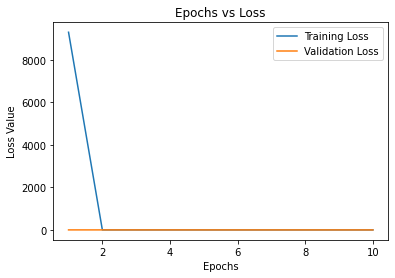

In [9]:
def loss_curve(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    x_axis = range(1, len(history.history['loss'])+1)

    plt.figure()
    plt.plot(x_axis, train_loss, label="Training Loss")

    plt.plot(x_axis, val_loss, label="Validation Loss")

    plt.ylabel('Loss Value')
    plt.xlabel('Epochs')
    plt.title('Epochs vs Loss')
    plt.legend()

    print('Minimum Validation Loss is:' + str(min(val_loss)))
    print('Epoch: ' + str(val_loss.index(min(val_loss)) + 1))

history = model.fit(xtrain, ytrain, batch_size=128, validation_data=(xval, yval), epochs=10, shuffle=True, verbose=1)
loss_curve(history)